In [1]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator

from scipy.integrate import quad, nquad
from scipy import stats
from scipy.signal import savgol_filter


from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
import pickle
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

bh kick speed = 100
3e-7 pbh mass
f = 1e-4
long = 1.0
lat = -1.03
distribution of t_es
cadence =
tobs = 1875

In [2]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [3]:
roman_df = pd.read_csv('roman_sensitivity.csv', header=None, names=['t_e [days]', 'efficiency'])
roman_efficiency_interp = interp1d(roman_df['t_e [days]'], roman_df['efficiency'])
def roman_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of Roman
    '''
    t_day = t/24
    if t_day <= np.min(roman_df['t_e [days]']):
        return roman_df['efficiency'][0]
    if t_day >= np.max(roman_df['t_e [days]']):
        return roman_df['efficiency'][len(roman_df)-1]
    return(roman_efficiency_interp(t_day))

<function __main__.roman_efficiency(t)>

In [10]:
#A_t of 1.34 corresponds to u_t_point of 1, which is what Johnson uses in point-source regime
#A_t of 1.06 corresponds to u_t_point of ~2, which is what popsycle uses as u_0_max
#A_t of 1.01 corresponds to u_t_point of ~3.5, which is Johnson uses as 0.01 mag sensitivity

survey_param_dict = {
    "mock_roman": {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 6*72*24, "cadence": 15/60,  "n_sources": 2.4e8, "efficiency": roman_efficiency, "A_t": 1.34, "survey_area":0},

    # "mock_roman": {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 1825*24, "cadence": 15/60,  "n_sources": 1e7, "efficiency": roman_efficiency, "A_t": 1.06, "survey_area":0},
    # "mock_roman": {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 1825*24, "cadence": 15/60,  "n_sources": 1e7, "efficiency": roman_efficiency, "A_t": 1.34, "survey_area":0},

}

In [11]:
def scientific_format(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"${} \times 10^{{{}}}$".format(mantissa, int(exponent))

def scientific_format_less(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"$10^{{{}}}$".format(int(exponent))

In [12]:
# Define Time Array
s = Survey(**survey_param_dict["mock_roman"])
# t_es = np.logspace(np.log10(s.cadence)-0.5, np.log10(s.obs_time)+0.5, 60) #hours

def gamma_of_t(dgamma_dt, t, t_es):
    t_min = t * 10**(-0.1)
    t_max = t * 10**(0.1)
    diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))
    def diff_rates_interp(t):
        return 10**diff_rates_interp_log(np.log10(t))
    return quad(diff_rates_interp, t_min, t_max)[0]

def sample_crossing_times(t_es, gammas, n_samples):
    norm_gammas = gammas/np.sum(gammas)
    cdf = np.cumsum(norm_gammas)
    
    samples = []
    for _ in range(n_samples):
        r = np.random.rand()
        t_e_sample = np.interp(r, cdf, t_es)
        samples.append(t_e_sample)
    return np.array(samples)

In [13]:
s

Survey(l=1.0, b=-1.03, source_dist=8.5, obs_time=10368, cadence = 0.25, survey_area=0, n_sources=240000000.0, efficiency=<function roman_efficiency at 0x7f90b0bac310>)

In [15]:
#Finite-source important when U >= 1ish. M ~ Rs^2/(4 G d_s) (dL/ds)
Rs_pc = 2.3e-8
G_pc = 4.3e-3
ds_pc = 8.5e3
dl_pc = ds_pc/2 # Try 3/4 of the way to the source instead
print(Rs_pc**2 / (4 * G_pc * ds_pc) *(dl_pc/ds_pc)*(3e5)**2/(3e-6) )
print(Rs_pc**2 / (4 * G_pc * ds_pc*(1-dl_pc/ds_pc)) *(dl_pc/ds_pc)*(3e5)**2/2 ) #Location in solar masses


0.0542749658002736
1.628248974008208e-07


Line of Sight

In [10]:
def plot_line_of_sight(s, ax):
    d_arr = np.linspace(1, s.source_dist, num=1000)

    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    rho_dm_mw = [s.mw_model.density_dm(d, l = s.l, b = s.b) for d in d_arr]
    ax.plot(d_arr, rho_ffp_mw, label="MW UBOs")
    ax.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")

    ax.set_xlabel(r"$d$ [kpc]", fontsize=16)
    ax.set_ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
    ax.set_title(r'MW Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)

    ax.legend(fontsize=14)

    ax.set_yscale("log")
    ax.set_xlim(1e0, s.source_dist)
    ax.set_ylim(1e5, 1e10)


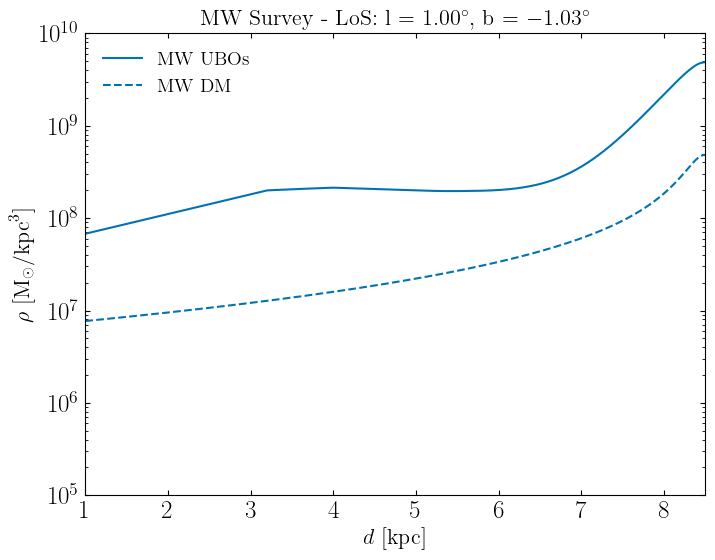

In [11]:
plot_line_of_sight(s, plt.gca())

In [7]:
# Initialize an empty dictionary
data_structure = {
    "ffp": {},
    "pbh": {}
}

def store_values(case, finite, v_disp, p=None, mass=None, t_es=None, calculated_values=None, sigma=None):
    if case not in data_structure:
        raise ValueError("Invalid case. Valid cases are 'ffp' and 'pbh'.")

    if finite not in data_structure[case]:
        data_structure[case][finite] = {}

    if v_disp not in data_structure[case][finite]:
        data_structure[case][finite][v_disp] = {}

    if mass not in data_structure[case][finite][v_disp]:
        data_structure[case][finite][v_disp][mass] = {}

    
    if case == "ffp":
        if p is not None:
            data_structure[case][finite][v_disp][p] = {
                "t_es": t_es,
                "calculated_values": calculated_values
            }
        else:
            raise ValueError("Parameter 'p' is required for case 'ffp'.")
        
    elif case == "pbh":
        if mass is not None:
            data_structure[case][finite][v_disp][mass][sigma] = {
                "t_es": t_es,
                "calculated_values": calculated_values
            }
        else:
            raise ValueError("Parameter 'mass' is required for case 'pbh'.")


In [9]:
t_es = np.logspace(-1, 4.8, 50) #hours

v_disp_pbh = 250
pbh_masses = np.logspace(-10, 2, 40)
sigmas = np.array([0.1, 0.5, 1.0])

t_low_cut = s.cadence
t_high_cut = s.obs_time


def differential_rate_mw_duration_pbh(t, s=s, finite=True):
    return s.pbh.differential_rate_mw(t, finite=finite, v_disp=v_disp_pbh, t_e=False)

def differential_rate_mw_duration_pbh_lognorm(t, s=s, finite=True):
    return s.pbh.differential_rate_mw_lognorm(t, finite=finite, v_disp=v_disp_pbh, t_e=False)

for mass in tqdm(pbh_masses):
    # for sigma in sigmas:
        # s.add_pbh(mass, lognorm=True, sigma=sigma)
    s.add_pbh(mass)


        # with Pool() as pool:
        #     func = functools.partial(differential_rate_mw_duration_pbh, s=s, finite=False)
        #     pbh_duration_point  = list(tqdm(pool.imap(func, t_es), total=len(t_es)))
        # pbh_duration_point = np.array(pbh_duration_point)

    with Pool() as pool:
        func = functools.partial(differential_rate_mw_duration_pbh, s=s, finite=True)
        pbh_duration_finite  = list(pool.imap(func, t_es))
    pbh_duration_finite = np.array(pbh_duration_finite)

        # with Pool() as pool:
        #     func = functools.partial(differential_rate_mw_duration_pbh_lognorm, s=s, finite=True)
        #     pbh_duration_finite  = list(pool.imap(func, t_es))
        # pbh_duration_finite = np.array(pbh_duration_finite)

        # store_values(case="pbh", finite=False, v_disp=v_disp_pbh, mass=mass, t_es=t_es, calculated_values=pbh_tes_point)
        # store_values(case="pbh", finite=True, v_disp=v_disp_pbh, mass=mass, t_es=t_es, calculated_values=pbh_duration_finite, sigma=sigma)
    store_values(case="pbh", finite=True, v_disp=v_disp_pbh, mass=mass, t_es=t_es, calculated_values=pbh_duration_finite)
        # store_values(case="pbh", finite=False, v_disp=v_disp_pbh, mass=mass, t_es=t_es, calculated_values=pbh_duration_point)



100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


### FFPs

In [14]:
t_es_ffps = np.logspace(-2, 4.8, 50) #hours

M_norm = 3e-6
Z_fiducial = 10
v_disp_ffp = 200

p_arr = np.linspace(0.66, 1.33, 16)

t_low_cut = s.cadence
t_high_cut = s.obs_time



def differential_rate_mw_duration(t, s=s, finite=False):
    v_disp_ffp = 200
    return s.ffp.differential_rate_mw(t, finite=finite, v_disp=v_disp_ffp, t_e=False)

for p in p_arr:
    s.add_ffp(p, m_min = 1e-12, m_max = 1e-1)

    z_earth =  Z_fiducial/(s.ffp.Z*(M_norm/s.ffp.M_norm)**(-p))

    with Pool() as pool:
        func_ffp = functools.partial(differential_rate_mw_duration, s=s, finite=True)
        ffp_t_duration_finite  = list(tqdm(pool.imap(func_ffp, t_es_ffps), total=len(t_es_ffps)))
    ffp_t_duration_finite = np.array(ffp_t_duration_finite)

    # with Pool() as pool:
    #     func_ffp = functools.partial(differential_rate_mw_duration, s=s, finite=False)
    #     ffp_t_duration_point  = list(tqdm(pool.imap(func_ffp, t_es_ffps), total=len(t_es_ffps)))
    # ffp_t_duration_point = np.array(ffp_t_duration_point)

    # ffp_tes_point = ffp_tes_point*z_earth
    ffp_t_duration_finite = ffp_t_duration_finite*z_earth
    # ffp_t_duration_point = ffp_t_duration_point*z_earth


    # store_values(case="ffp", finite=False, v_disp=v_disp_ffp, p=p, t_es=t_es_ffps, calculated_values=ffp_tes_point)
    store_values(case="ffp", finite=True, v_disp=v_disp_ffp, p=p, t_es=t_es_ffps, calculated_values=ffp_t_duration_finite)
    # store_values(case="ffp", finite=False, v_disp=v_disp_ffp, p=p, t_es=t_es_ffps, calculated_values=ffp_t_duration_point)



  0%|          | 0/50 [00:00<?, ?it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:204: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(integrand_logm, logm_min, logm_max, epsabs=epsabs, epsrel=epsrel)
  2%|▏         | 1/50 [08:58<7:19:38, 538.33s/it]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:204: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the diffic

In [56]:
def plot_data_structure(data_structure):
    num_entities = len(data_structure)
    fig, axes = plt.subplots(num_entities, 1, figsize=(6, 4*num_entities), sharex=True)

    for idx, (entity, entity_data) in enumerate(data_structure.items()):
        ax = axes[idx]
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for p_or_mass, p_or_mass_data in v_disp_data.items():
                    if entity == "ffp":
                        ax.loglog(p_or_mass_data['t_es'], p_or_mass_data['calculated_values'], label=f'p={p_or_mass}, v_disp={v_disp}, finite={finite_val}')
                    else: #pbh
                        for sigma, sigma_data in p_or_mass_data.items():  # Loop over sigma level
                            ax.loglog(sigma_data['t_es'], sigma_data['calculated_values'], label=f'mass={p_or_mass}, sigma={sigma}, v_disp={v_disp}, finite={finite_val}')
        
        ax.set_xlabel('t [hours]')
        ax.set_ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
        ax.set_ylim(1e-16, 1e-4)
        ax.set_title(f'{entity}')
        # ax.legend()
    plt.tight_layout()
    plt.show()

def plot_gammas(data_structure):
    num_entities = len(data_structure)
    fig, axes = plt.subplots(num_entities, 1, figsize=(6, 4*num_entities))

    for idx, (entity, entity_data) in enumerate(data_structure.items()):
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for p_or_mass, p_or_mass_data in v_disp_data.items():
                    if entity == "ffp":
                        # Calculate gamma(t) for each case
                        t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                        gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                        # Plot gamma(t)
                        axes[idx].loglog(t_es_limited, gammas, label=f'p_or_mass={p_or_mass}, v_disp={v_disp}, finite={finite_val}')
                    else: #pbh
                        for sigma, sigma_data in p_or_mass_data.items():  # Loop over sigma level
                            axes[idx].loglog(sigma_data['t_es'], sigma_data['calculated_values'], label=f'mass={p_or_mass}, sigma={sigma}, v_disp={v_disp}, finite={finite_val}', linestyle='--')


        axes[idx].set_xlabel(r'$t_E$ [hours]')
        axes[idx].set_ylabel(r'$\Gamma(t)$')
        axes[idx].set_ylim(1e-16, 1e-5)
        axes[idx].set_title(f'{entity}')
        # axes[idx].legend()
        
    plt.tight_layout()
    plt.show()

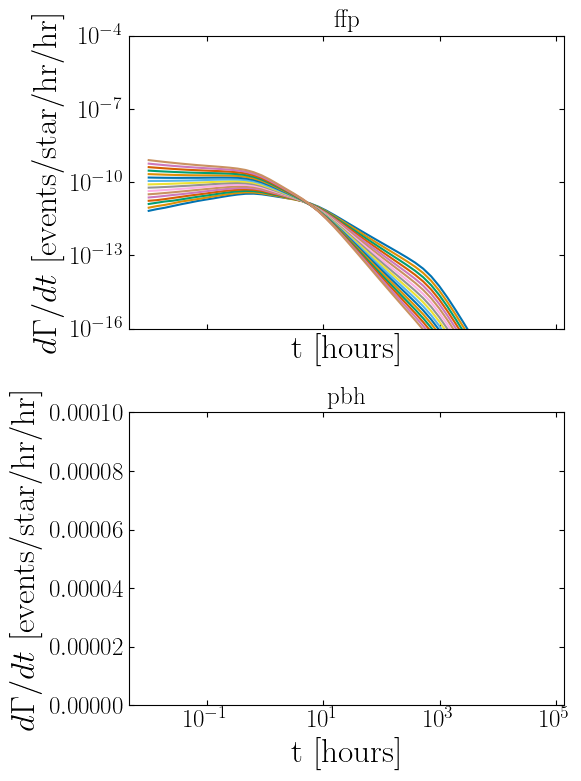

In [57]:
plot_data_structure(data_structure)

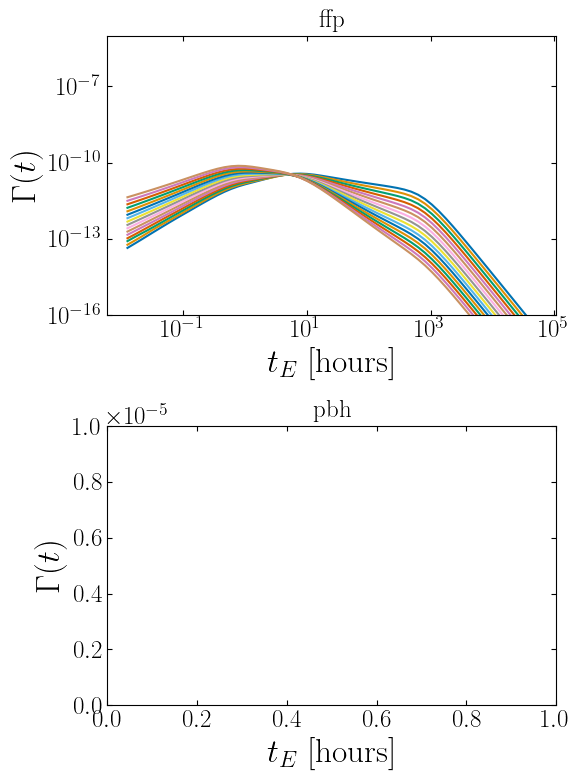

In [58]:
plot_gammas(data_structure)

In [66]:
def create_gamma_interp_ffp(data_structure):
    t_values = []
    p_values = []
    gamma_values = []
    dgammadt_values = []

    for idx, (entity, entity_data) in enumerate(data_structure.items()):
        if entity != "ffp":
            continue
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for p_or_mass, p_or_mass_data in v_disp_data.items():
                    t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                    gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                    t_values.extend(p_or_mass_data['t_es'])

                    p_values.extend([p_or_mass] * len(t_es_limited))
                    gamma_values.extend(gammas)
                    dgammadt_values.extend(p_or_mass_data['calculated_values'])

    # Evaluate the gamma values at the points in the grid
    gamma_values_grid = np.array(gamma_values).reshape(len(p_arr), (len(t_es_limited)))
    dgammadt_values_grid = np.array(dgammadt_values).reshape(len(p_arr), (len(np.unique(t_values))))

    # Create an interpolating function
    gamma_interpolating_function = RegularGridInterpolator((np.log10(p_arr), np.log10(t_es_limited)), np.log10(gamma_values_grid), method='linear')
    dgammadt_interpolating_function = RegularGridInterpolator((np.log10(p_arr), np.log10(np.unique(t_values))), np.log10(dgammadt_values_grid), method='linear')


    # return gamma_interpolating_function
    return dgammadt_interpolating_function, gamma_interpolating_function

def create_gamma_interp_pbh(data_structure):
    t_values = []
    t_values_limited = []
    m_values = []
    sigma_values = []
    dgammadt_values = []
    gamma_values = []

    # Extracting data and populating lists
    for entity, entity_data in data_structure.items():
        if entity != "pbh":
            continue
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for mass, mass_data in v_disp_data.items():
                    for sigma, sigma_data in mass_data.items():
                        t_es_limited = np.logspace(
                            np.log10(np.min(sigma_data['t_es'])) + 0.1, 
                            np.log10(np.max(sigma_data['t_es'])) - 0.1, 
                            60
                        )
                        gammas = np.array([
                            gamma_of_t(sigma_data['calculated_values'], t, t_es=sigma_data['t_es']) 
                            for t in t_es_limited
                        ])

                        t_values.extend(sigma_data['t_es'])
                        t_values_limited.extend(t_es_limited)
                        m_values.extend([mass] * len(t_es_limited))
                        sigma_values.extend([sigma] * len(t_es_limited))
                        dgammadt_values.extend(sigma_data['calculated_values'])
                        gamma_values.extend(gammas)
    
    # Ensure you have unique and sorted values for interpolation grid
    unique_t = np.unique(t_values)
    unique_t_limited = np.unique(t_values_limited)
    unique_m = np.unique(m_values)
    # unique_sigma = np.unique(sigma_values)
    
    # Reshaping data for grid interpolation
    
    #log-norm

    # dgammadt_values_grid = np.array(dgammadt_values).reshape(len(unique_m), len(unique_sigma), len(unique_t))
    # gamma_values_grid = np.array(gamma_values).reshape(len(unique_m), len(unique_sigma), len(unique_t_limited))
    # dgammadt_interpolating_function = RegularGridInterpolator(
    #     (np.log10(unique_m), np.log10(unique_sigma), np.log10(unique_t)), 
    #     np.log10(dgammadt_values_grid), 
    #     method='linear'
    # )

    # gamma_interpolating_function = RegularGridInterpolator(
    #     (np.log10(unique_m), np.log10(unique_sigma), np.log10(unique_t_limited)), 
    #     np.log10(gamma_values_grid), 
    #     method='linear'
    # )

    #mono
    dgammadt_values_grid = np.array(dgammadt_values).reshape(len(unique_m), len(unique_t))
    gamma_values_grid = np.array(gamma_values).reshape(len(unique_m), len(unique_t_limited))

    dgammadt_interpolating_function = RegularGridInterpolator(
        (np.log10(unique_m), np.log10(unique_t)), 
        np.log10(dgammadt_values_grid), 
        method='linear'
    )
    gamma_interpolating_function = RegularGridInterpolator(
        (np.log10(unique_m), np.log10(unique_t_limited)), 
        np.log10(gamma_values_grid), 
        method='linear'
    )

    return dgammadt_interpolating_function, gamma_interpolating_function

In [14]:
dgammadt_interpolating_function_pbh, gamma_interpolating_function_pbh = create_gamma_interp_pbh(data_structure)

# pickle.dump(dgammadt_interpolating_function_pbh, open("interps/dgammadt_func_pbh_finite_mono_new.p", "wb"))
# pickle.dump(gamma_interpolating_function_pbh, open("interps/gamma_func_pbh_finite_sigma_mono_new.p", "wb"))

# pickle.dump(dgammadt_interpolating_function_pbh, open("interps/dgammadt_func_pbh_finite_sigma_all_new.p", "wb"))
# pickle.dump(gamma_interpolating_function_pbh, open("interps/gamma_func_pbh_finite_sigma_all_new.p", "wb"))


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_19947/3285702519.py:8: RuntimeWarning: divide by zero encountered in log10
  diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_19947/3149792135.py:125: RuntimeWarning: divide by zero encountered in log10
  np.log10(dgammadt_values_grid),
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_19947/3149792135.py:136: RuntimeWarning: divide by zero encountered in log10
  np.log10(gamma_values_grid),


In [30]:
dgammadt_func_pbh_finite = dgammadt_interpolating_function_pbh

In [125]:
# dgammadt_func_pbh_finite = pickle.load(open("interps/dgammadt_func_pbh_finite.p", "rb"))
dgammadt_func_pbh_finite = pickle.load(open("interps/dgammadt_func_pbh_finite_mono_new.p", "rb"))
gamma_func_pbh_finite = pickle.load(open("interps/gamma_func_pbh_finite_sigma_mono_new.p", "rb"))


In [130]:
dgammadt_interpolating_function_pbh = pickle.load(open("interps/dgammadt_func_pbh_finite_sigma_all_new.p", "rb"))
# gamma_interpolating_function_pbh = pickle.load(open("interps/gamma_func_pbh_finite_sigma_all.p", "rb"))


In [68]:
dgammadt_func_ffp_finite, gamma_func_ffp_finite = create_gamma_interp_ffp(data_structure)
# pickle.dump(dgammadt_func_ffp_finite, open("interps/dgammadt_func_ffp_finite_new.p", "wb"))
# pickle.dump(gamma_func_ffp_finite, open("interps/gamma_func_ffp_finite_new.p", "wb"))
# dgammadt_func_ffp_finite = pickle.load(open("interps/dgammadt_func_ffp_finite.p", "rb"))


In [14]:
# pickle.dump(gamma_func_ffp_finite, open("interps/gamma_func_ffp_finite.p", "wb"))
# gamma_func_ffp_point = create_gamma_interp_ffp(data_structure)
# pickle.dump(gamma_func_ffp_point, open("interps/gamma_func_ffp_point.p", "wb"))
gamma_func_ffp = pickle.load(open("interps/gamma_func_ffp_point.p", "rb"))
gamma_func_ffp_finite = pickle.load(open("interps/gamma_func_ffp_finite.p", "rb"))


In [20]:
def gamma_wrapper_pbh_lognorm(m, sigma, t):
    return 10**(dgammadt_interpolating_function_pbh([[np.log10(m), np.log10(sigma), np.log10(t)]]))[0] * s.efficiency(t)

In [21]:
ts = np.logspace(-1, 2.9, 100)
m = 1e-7
diff_rate_15 = np.array([gamma_wrapper_pbh_lognorm(m, 1.5, t) for t in ts])
diff_rate_1 = np.array([gamma_wrapper_pbh_lognorm(m, 1, t) for t in ts])
diff_rate_01 = np.array([gamma_wrapper_pbh_lognorm(m, 0.1, t) for t in ts])


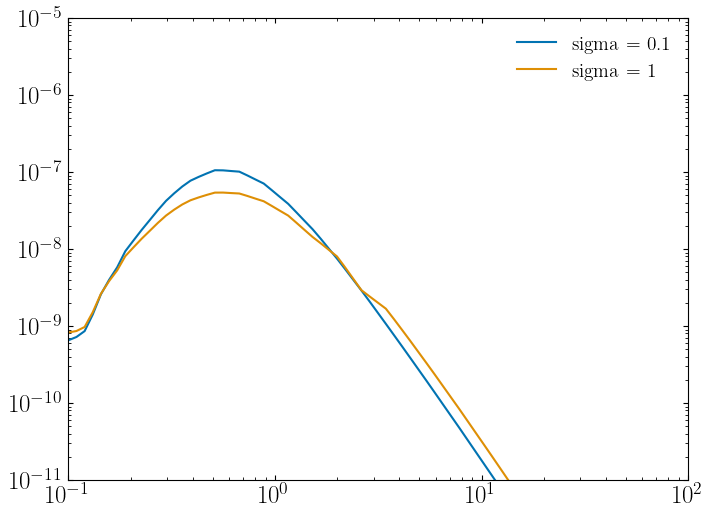

In [22]:
plt.loglog(ts, diff_rate_01, label="sigma = 0.1")
plt.loglog(ts, diff_rate_1, label="sigma = 1")
plt.ylim(1e-11, 1e-5)
plt.xlim(1e-1, 1e2)

plt.legend()

## Yield and comparison to Johnson

In [178]:
#Translate between mass function normalization between us and Johnson for fiducial mass function
(95**(0.73) * 0.24)/10

0.6667291964938795

In [128]:
def yield_ffp(p):
    def gamma_wrapper(t):
        return 10**(dgammadt_func_ffp_finite([[np.log10(p), np.log10(t)]])) * s.efficiency(t)
    return quad(gamma_wrapper, 0.25, 24*72*6, epsabs=0, epsrel=1e-1, points=[1, 10])[0] * 2.4e8 * 24*72*6

def yield_pbh(m):
    def gamma_wrapper(t):
        return 10**(dgammadt_func_pbh_finite([[np.log10(m), np.log10(t)]])) * s.efficiency(t)
    return quad(gamma_wrapper, 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0] * 2.4e8 * 24*72*6

def yield_pbh_lognorm(m, sigma):
    def gamma_wrapper(t):
        return 10**(dgammadt_interpolating_function_pbh([[np.log10(m), np.log10(sigma), np.log10(t)]])) * s.efficiency(t)
    return quad(gamma_wrapper, 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0] * 2.4e8 * 24*72*6


In [70]:
yield_ffp(0.73)*0.667 

316.64084819172757

In [132]:
masses_dense = np.logspace(-10, 1, 100)
yields_mono = np.array([yield_pbh(m) for m in masses_dense])
yields_sigma_1 = np.array([yield_pbh_lognorm(m, 1) for m in masses_dense])
yields_sigma_05 = np.array([yield_pbh_lognorm(m, 0.5) for m in masses_dense])
yields_sigma_01 = np.array([yield_pbh_lognorm(m, 0.1) for m in masses_dense])


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_20073/3970690004.py:11: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(gamma_wrapper, 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0] * 2.4e8 * 24*72*6
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_20073/3970690004.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(gamma_wrapper, 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0] * 2.4e8 * 24*72*6
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_20073/3970690004.py:17: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
 

In [166]:
window_length = 8
polyorder = 1
yields_mono_smooth = savgol_filter(yields_mono, window_length, polyorder)
yields_sigma_05_smooth = savgol_filter(yields_sigma_05, window_length, polyorder)
yields_sigma_1_smooth = savgol_filter(yields_sigma_1, window_length, polyorder)
yields_sigma_01_smooth = savgol_filter(yields_sigma_01, window_length, polyorder)


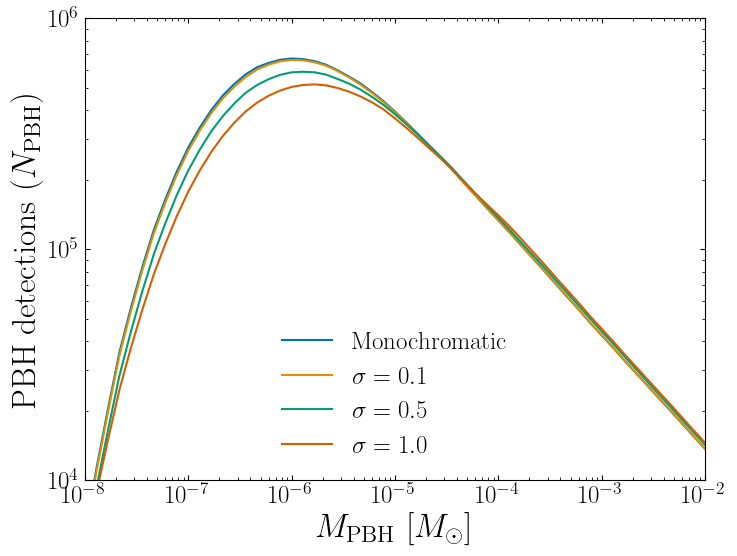

In [390]:
plt.plot(masses_dense, yields_mono_smooth, label="Monochromatic", color='C0')
plt.plot(masses_dense, yields_sigma_01_smooth, label=r"$\sigma = 0.1$", color='C1')
plt.plot(masses_dense, yields_sigma_05_smooth, label=r"$\sigma = 0.5$", color='C2')
plt.plot(masses_dense, yields_sigma_1_smooth, label=r"$\sigma = 1.0$", color='C3')



plt.xscale("log")
plt.yscale("log")
plt.ylim(1e4,1e6)
plt.xlim(1e-8, 1e-2)
plt.xlabel(r"$M_{\rm{PBH}} ~[M_{\odot}]$")
plt.ylabel(r"PBH detections ($N_{\rm{PBH}}$)")

plt.legend(fontsize=18)
# plt.savefig("figures/pbh_estimated_yield.pdf")

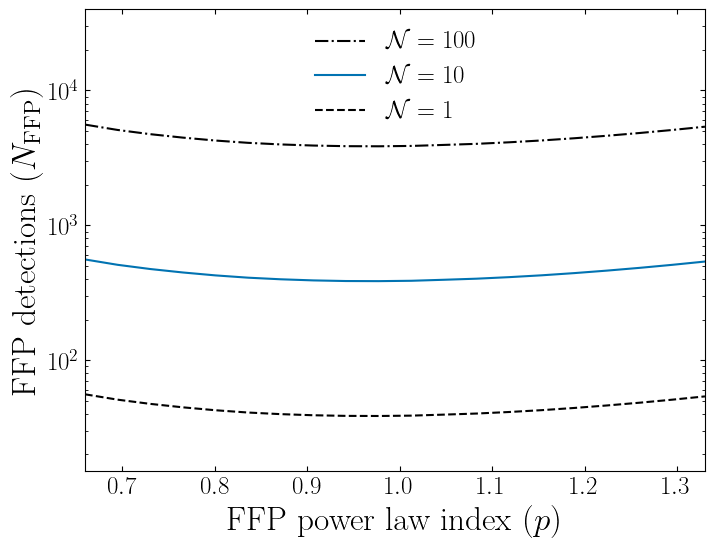

In [232]:
p_arr_test = np.linspace(0.66, 1.33, 20)
our_yield = np.array([yield_ffp(p) for p in p_arr_test])
plt.plot(p_arr_test, our_yield*10, label=r'$\mathcal{N} = 100$', ls='-.', color='k')
plt.plot(p_arr_test, our_yield, label=r'$\mathcal{N} = 10$')
plt.plot(p_arr_test, our_yield*0.1, label=r'$\mathcal{N} = 1$', ls='--', color='k')


plt.xlim(0.66, 1.33)
plt.ylim(15, 4e4)

plt.ylabel(r"FFP detections ($N_{\rm{FFP}}$)")
plt.xlabel(r"FFP power law index ($p$)")
plt.yscale("log")
plt.legend(loc='upper center', fontsize=18)
# plt.savefig('figures/ffp_estimated_yield_comparison_new.pdf')
plt.show()

In [238]:
rho_arr = np.logspace(-2, 0.7, 1000)
A_t = 1.34
my_ut_arr = np.array([ut_func_new(rho, A_t) for rho in rho_arr])
j_ut_arr = np.array([max(1, 2*rho) for rho in rho_arr])
j_ut_alt_arr = np.array([max(3, 2*rho) for rho in rho_arr])


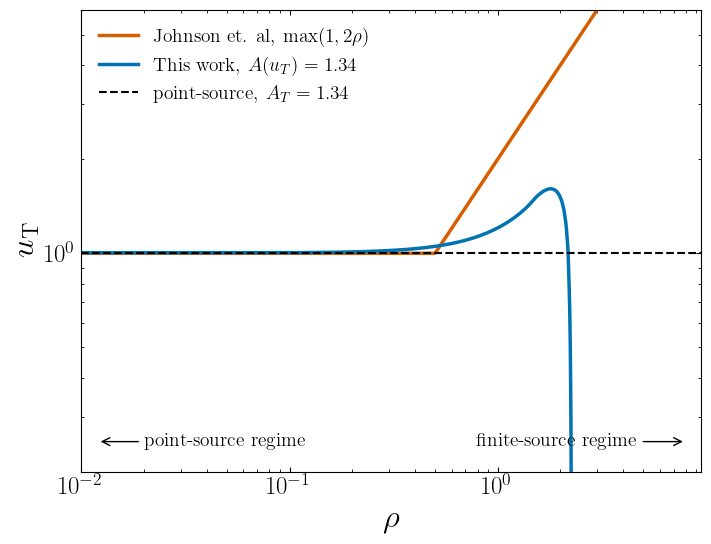

In [388]:
plt.plot(rho_arr, j_ut_arr, label=r'Johnson et. al, $\rm{max}(1, 2\rho)$', color='C3', linewidth=2.5)
plt.plot(rho_arr, my_ut_arr, label=r'This work, $A(u_T) = 1.34$', color='C0', linewidth=2.5)
plt.axhline(1., color='k', linestyle='--', label=r'point-source, $A_T = 1.34$')


plt.annotate('point-source regime', xy=(0.012, 0.25), xytext=(0.02, 0.25),
             arrowprops=dict(facecolor='black', arrowstyle = '->'),
             horizontalalignment='left', verticalalignment='center', fontsize=14)

plt.annotate('finite-source regime', xy=(8.0, 0.25), xytext=(4.7, 0.25),
             arrowprops=dict(facecolor='black',  arrowstyle = '->'),
             horizontalalignment='right', verticalalignment='center', fontsize=14)


plt.axvline()

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$u_{\rm T}$')
plt.xlim(1e-2, 0.95e1)
plt.ylim(2e-1, 6e0)
# plt.savefig('figures/ut_comparison.pdf')
plt.show()


## Lognormal comparison to Johnson

In [ ]:
mass_arr = np.logspace(-2, 4, 7)*3e-6
ts = np.logspace(np.log10(0.25), np.log10(24*72*6), 30)


In [ ]:
result_arr_point_1 = np.zeros(len(mass_arr))
for i, m in enumerate(tqdm(mass_arr)):
    f = Ffp(0, l = 1.0, b = -1.03, ds=8.5, u_t = 1, m_min=m*10**(-0.5), m_max=m*10**(0.5))
    dgdt_arr = np.array([f.differential_rate_mw(t, finite=False, v_disp=220) for t in ts])
    dgdt_interp = interp1d(ts, dgdt_arr, kind='linear')

    rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
    result_arr_point_1[i] = rate * 24*72*6 * 2.4e8

 43%|████▎     | 3/7 [01:40<02:15, 33.82s/it]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14517/3939466292.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
100%|██████████| 7/7 [05:04<00:00, 43.52s/it]


In [ ]:
our_ut_1_finite = np.array([0.054581, 1.747823, 18.989170 , 72.575551, 233.820611, 744.041794, 2372.639453]) #fiducial 
our_ut_1_point =  np.array([6.66058132e-01, 4.51597126e+00, 1.91777526e+01, 6.94530989e+01,2.29975935e+02, 7.40354621e+02, 2.36208973e+03])
result_arr_point_1 = np.array([6.66058132e-01, 4.51597126e+00, 1.91777526e+01, 6.94530989e+01, 2.29975935e+02, 7.40354621e+02, 2.36208973e+03])
result_arr_point_3 = np.array([4.19731590e+00, 1.84469580e+01, 6.56940092e+01, 2.17129007e+02, 7.01789494e+02, 2.24181653e+03, 7.11845702e+03])
result_arr_point_35 = np.array([5.09027157e+00, 2.15841384e+01, 7.61618731e+01, 2.51482464e+02, 8.08879645e+02, 2.57807882e+03, 8.16249999e+03])


In [ ]:
johnson_logn_new = np.array([0.306, 4.49, 22.1, 87.1, 313, 1025, 3329])
johnson_fid_new = np.array([0.611, 8.97, 44.2, 108, 72.3, 44.1, 26.7])
N_power_our_fid_arr= []
for m in mass_arr:
    N_power_our_fid_arr.append(10*(m/(3e-6))**(-1))
N_power_our_fid_arr = np.array(N_power_our_fid_arr)

N_power_new_arr= []
for m in mass_arr:
    N_power_new_arr.append(0.24*(m/(95*3e-6))**(-0.73))
N_power_new_arr = np.array(N_power_new_arr)


In [ ]:
our_ut_1_point/johnson_logn_new

array([2.17666056, 1.00578424, 0.86777161, 0.79739494, 0.7347474 ,
       0.72229719, 0.70954933])

In [ ]:
our_ut_1_finite/johnson_logn_new

array([0.17836928, 0.38927016, 0.85923846, 0.83324398, 0.74703071,
       0.72589443, 0.71271837])

In [ ]:
df = pd.DataFrame({'m [M_earth]': np.round(mass_arr/3e-6,2), 'Our Log-Uniform': result_arr, 'Johnson Log-Uniform': johnson_logn_new, 'Our Fiducial': N_power_our_fid_arr*result_arr, 'Johnson Fiducial Power': johnson_logn_new*N_power_new_arr})
print(df)

   m [M_earth]  Our Log-Uniform  Johnson Log-Uniform  Our Fiducial  \
0         0.01         0.054581                0.306     54.580964   
1         0.10         1.747823                4.490    174.782304   
2         1.00        18.989170               22.100    189.891703   
3        10.00        72.575551               87.100     72.575551   
4       100.00       233.820611              313.000     23.382061   
5      1000.00       744.041794             1025.000      7.440418   
6     10000.00      2372.639453             3329.000      2.372639   

   Johnson Fiducial Power  
0               58.839761  
1              160.766595  
2              147.347152  
3              108.135335  
4               72.359209  
5               44.123844  
6               26.684758  


In [ ]:
#full power law comparison
M_norm = 3e-6
Z_fiducial = 10
f = Ffp(1, l = 1.0, b = -1.03, ds=8.5, u_t = 1, m_min=1e-12, m_max= 1e-1)
z_earth =  Z_fiducial/(f.Z*(M_norm/f.M_norm)**(-p))
dgdt_arr = np.array([f.differential_rate_mw(t, finite=True, v_disp=220) for t in tqdm(ts)])
dgdt_interp = interp1d(ts, dgdt_arr, kind='linear')

rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
print(rate * 24*72*6 * 2.4e8 * z_earth)

In [ ]:
#Should be close to for power-law calc and log-uniform calc to agree
sum(N_power_our_fid_arr*result_arr)

525.0256409207203

Text(0, 0.5, 'Number of Events')

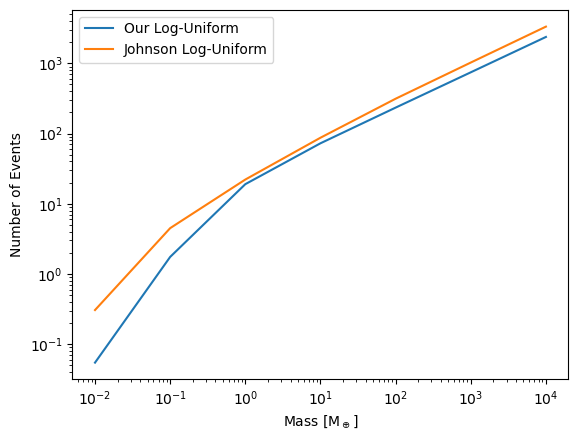

In [ ]:
plt.loglog(mass_arr/3e-6, result_arr, label='Our Log-Uniform')
plt.loglog(mass_arr/3e-6, johnson_logn_new, label='Johnson Log-Uniform')
plt.legend()
plt.xlabel('Mass [M$_\oplus$]')
plt.ylabel('Number of Events')


## Comparison with Popsycle

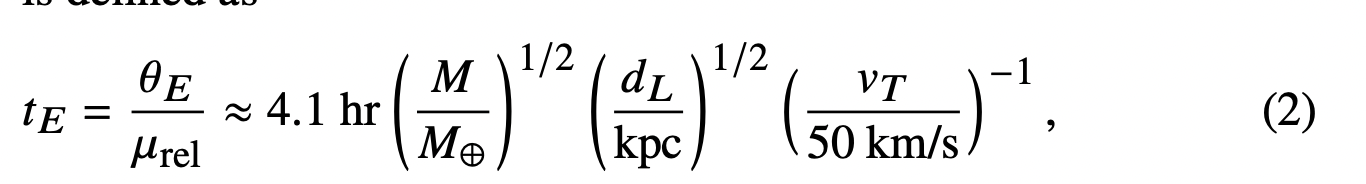

In [108]:
# t_e_typical = 4.1 * (1e7)**(1/2) * (4)**(1/2) * (280/50)**(-1) / 24 # 30 solar mass, days
t_e_typical = 4.1 * (1)**(1/2) * (1)**(1/2) * (200/50)**(-1) #earth mass, hours
print(t_e_typical)

1.025


In [ ]:
t_e_typical = 4.1 * (1e7)**(1/2) * (4)**(1/2) * (280/50)**(-1) / 24 # 30 solar mass, days


In [88]:
4.1 * (1e-6)**(1/2) * (8)**(1/2) * (220/50)**(-1) #earth mass, hours

0.0026355798207862223

In [92]:
nick_tes_30 = pd.read_csv('popsycle_data/nick-t_E-30msun-sep8-nocut.csv', header=None).values.flatten()
nick_tes_earth = pd.read_csv('popsycle_data/nick-t_E-earthmass-sep8.csv', header=None).values.flatten()
nick_tes_data = {
    3e-6: nick_tes_earth, 
    30: nick_tes_30 
}

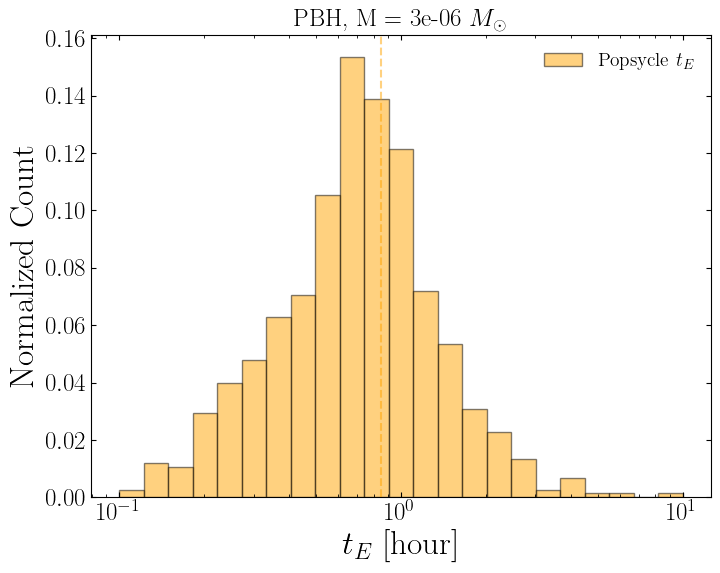

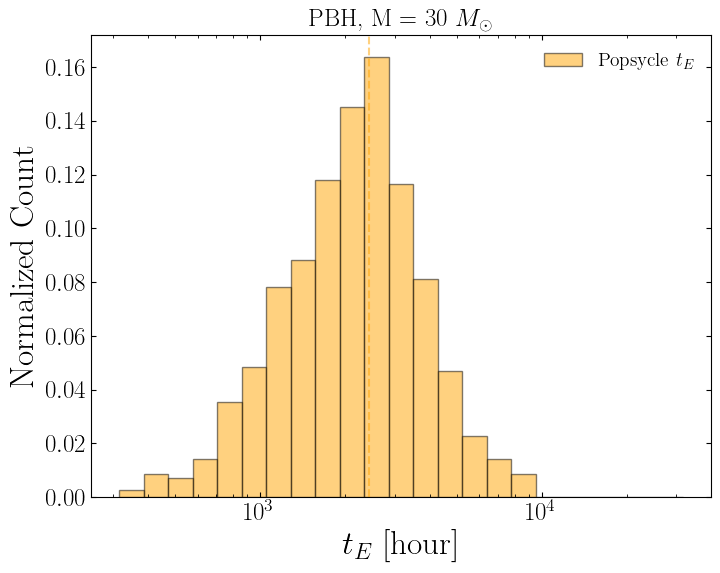

In [93]:
def plot_histograms(data_structure, nick_tes_data, num_samples=10000, num_bins=24):

    for m_pbh, nick_tes in nick_tes_data.items():
        if m_pbh == 3e-6:
            bins = np.logspace(-1, 1, num_bins)
        elif m_pbh == 30:
            bins = np.logspace(2.5, 4.5, num_bins)

        plt.figure()
        for entity, entity_data in data_structure.items():
            for finite_val, finite_data in entity_data.items():
                if finite_val:
                    continue
                for v_disp, v_disp_data in finite_data.items():
                    for p_or_mass, p_or_mass_data in v_disp_data.items():
                        if entity != 'pbh' or p_or_mass != m_pbh:
                            continue
                        # Calculate gamma(t) for each case
                        t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                        gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                        
                        # Sample crossing times
                        samples = sample_crossing_times(t_es_limited, gammas, num_samples)
                        
                        # Plot histogram
                        bin_counts, bin_edges = np.histogram(samples, bins=bins)
                        plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LCP, Point, v_disp={v_disp}', alpha=0.5, color='blue')
                        plt.axvline(np.mean(samples), linestyle="--", alpha=0.5)

        # Plotting for Popsycle data
        bin_counts_popsycle, bin_edges_popsycle = np.histogram(nick_tes*24, bins=bins)
        plt.bar(bin_edges_popsycle[:-1], bin_counts_popsycle/np.sum(bin_counts_popsycle), width=np.diff(bin_edges_popsycle), align="edge", edgecolor="black", label=r"Popsycle $t_E$", alpha=0.5, color='orange')
        plt.axvline(np.mean(nick_tes*24), color='orange', linestyle="--", alpha=0.5)

        plt.xscale('log')
        plt.xlabel(r"$t_E$ [hour]")
        plt.ylabel("Normalized Count")
        plt.title(f"PBH, M = {m_pbh} $M_\odot$")
        plt.legend()
        plt.show()
        
plot_histograms(data_structure, nick_tes_data)


## FFPs

In [25]:
nick_ffp_df = pd.read_csv('popsycle_data/nick-t_E-Lmass-ffp-06-combined.csv', header=None)
nick_ffp_tes = nick_ffp_df[0].values
nick_ffp_masses = nick_ffp_df[1].values
# nick_ffp_tes_sampled_066 = 10**(pd.read_csv('popsycle_data/p066-logtE-sampled.csv', header=None).values.flatten())
# nick_ffp_tes_sampled_100 = 10**(pd.read_csv('popsycle_data/p100-logtE-sampled.csv', header=None).values.flatten())
# nick_ffp_tes_sampled_133 = 10**(pd.read_csv('popsycle_data/p133-logtE-sampled.csv', header=None).values.flatten())
nick_ffp_tes_sampled_066 = 10**(pd.read_csv('popsycle_data/lower1e-12-p066-logtE-sampled.csv', header=None).values.flatten())
nick_ffp_tes_sampled_100 = 10**(pd.read_csv('popsycle_data/lower1e-12-p100-logtE-sampled.csv', header=None).values.flatten())
nick_ffp_tes_sampled_133 = 10**(pd.read_csv('popsycle_data/lower1e-12-p133-logtE-sampled.csv', header=None).values.flatten())

nick_ffp_tes_data = {
    0.66: nick_ffp_tes_sampled_066,
    1.0: nick_ffp_tes_sampled_100,
    1.33: nick_ffp_tes_sampled_133
}

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_44185/3285702519.py:8: RuntimeWarning: divide by zero encountered in log10
  diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))


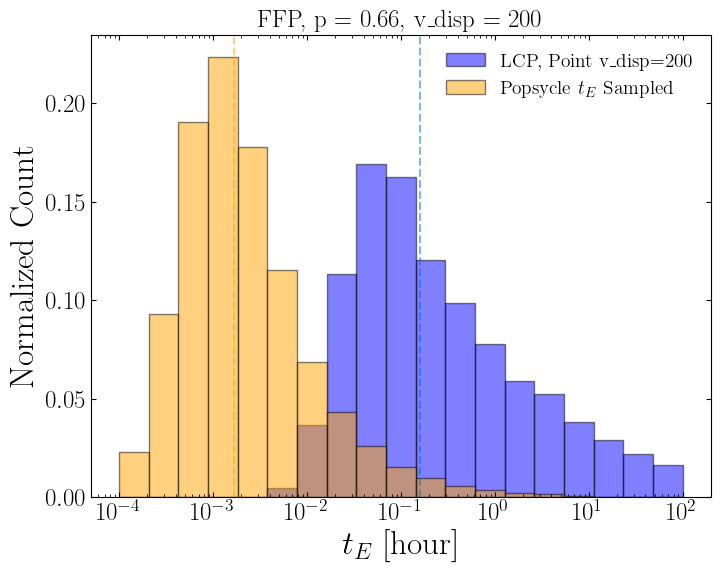

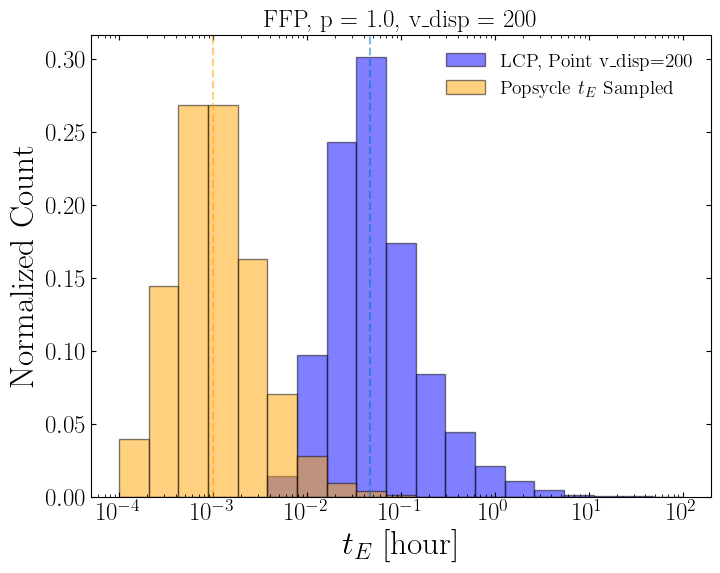

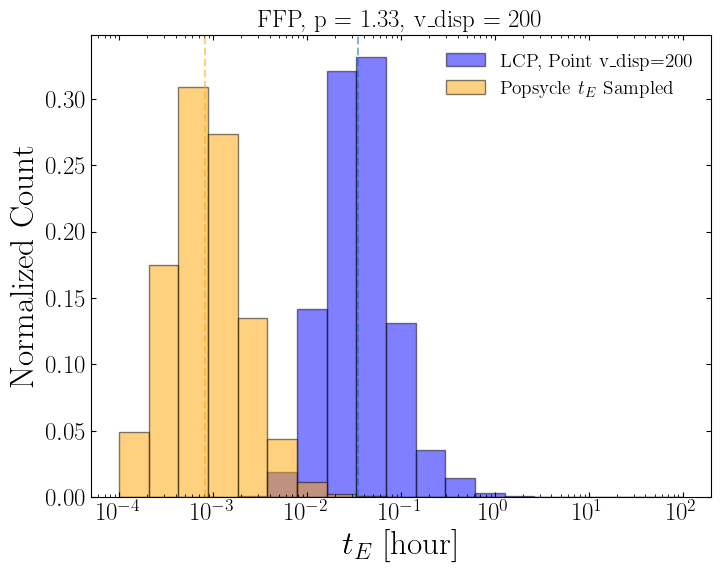

In [31]:
#With extended mass function, but cuts on t_duration at low and high
def plot_ffp_histograms(data_structure, nick_ffp_tes_data, num_samples=10000, num_bins=20):
    # bins = np.logspace(-2.5, 2, num_bins)
    bins = np.logspace(-4, 2, num_bins)


    for p_val, nick_ffp_tes_sampled in nick_ffp_tes_data.items():
        plt.figure()
        for entity, entity_data in data_structure.items():
            for finite_val, finite_data in entity_data.items():
                if finite_val:
                    continue
                for v_disp, v_disp_data in finite_data.items():
                    for p_or_mass, p_or_mass_data in v_disp_data.items():
                        if entity != 'ffp' or p_or_mass != p_val:
                            continue

                        # Calculate gamma(t) for each case
                        t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                        gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                        
                        # Sample crossing times
                        samples = sample_crossing_times(t_es_limited, gammas, num_samples)
                        
                        # Plot histogram
                        bin_counts, bin_edges = np.histogram(samples, bins=bins)
                        plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f'LCP, Point v_disp={v_disp}', alpha=0.5, color='blue')
                        plt.axvline(np.median(samples), linestyle="--", alpha=0.5)
                        plt.title(f"FFP, p = {p_val}, v_disp = {v_disp}")
                        
        # Plotting for Popsycle data
        bin_counts_popsycle_sampled, bin_edges_popsycle_sampled = np.histogram(nick_ffp_tes_sampled, bins=bins)
        plt.bar(bin_edges_popsycle_sampled[:-1], bin_counts_popsycle_sampled/np.sum(bin_counts_popsycle_sampled), width=np.diff(bin_edges_popsycle_sampled), align="edge", edgecolor="black", label=r"Popsycle $t_E$ Sampled", alpha=0.5, color='orange')
        plt.axvline(np.median(nick_ffp_tes_sampled), color='orange', linestyle="--", alpha=0.5)

        plt.xscale('log')
        plt.xlabel(r"$t_E$ [hour]")
        plt.ylabel("Normalized Count")
        plt.legend()
        plt.show()

plot_ffp_histograms(data_structure, nick_ffp_tes_data)


In [51]:
#px, py, pz, vx, vy, vz
stars = np.load('popsycle_data/star.npy')
ffps = np.load('popsycle_data/ffp.npy')
ffps_smaller_r = np.load('popsycle_data/ffp_smaller_r.npy')

(-800.0, 600.0)

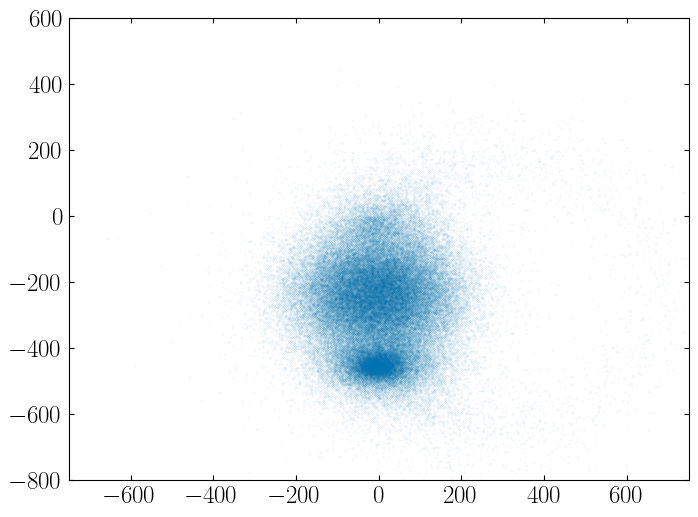

In [46]:
plt.plot(ffps[3], ffps[4], 'o', markersize=0.1, label='FFPs', alpha=0.3)
plt.xlim(-750, 750)
plt.ylim(-800, 600)

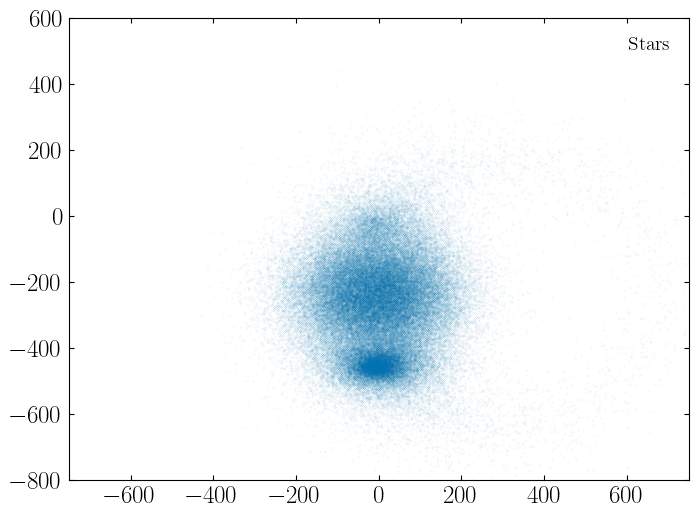

In [47]:
plt.plot(stars[3], stars[4], 'o', markersize=0.1, label='Stars', alpha=0.3)
plt.xlim(-750, 750)
plt.ylim(-800, 600)
plt.legend()

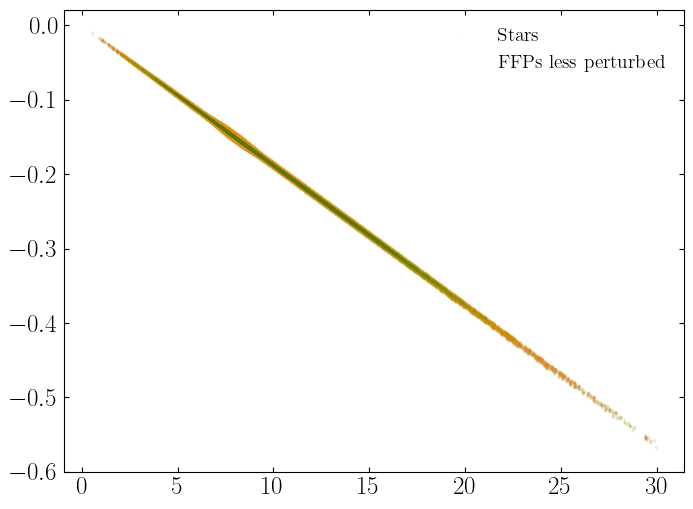

In [73]:
plt.plot(stars[0], stars[2], 'o', markersize=0.1, label='Stars', alpha=0.2)
# plt.plot(ffps[0], ffps[2], 'o', markersize=0.1, label='FFPs', alpha=0.05)
plt.plot(ffps_smaller_r[0], ffps_smaller_r[2], 'o', markersize=0.1, label='FFPs less perturbed', alpha=0.05)

plt.legend()

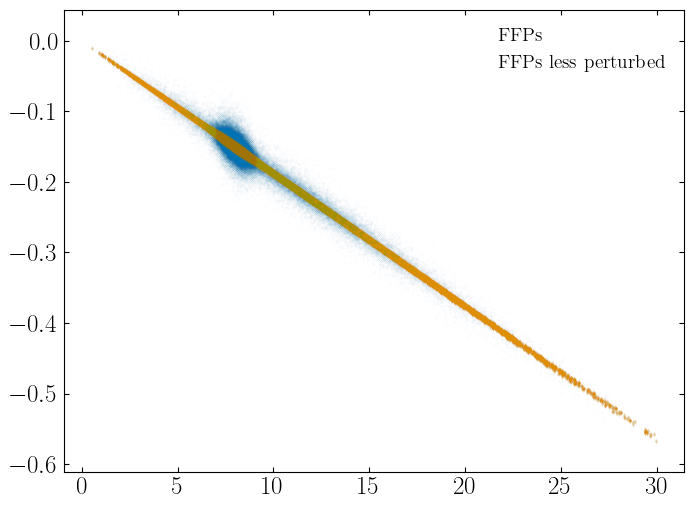

In [66]:


plt.legend()